In [5]:
import pandas as pd
import numpy as np

In [13]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [4]:
train.head()

,id,type,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,...,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
0,0,QSO,601,23.198224,21.431953,21.314148,21.176553,21.171444,22.581309,21.644453,...,22.504317,21.431636,21.478312,21.145409,20.422446,22.749241,21.465534,21.364187,21.020605,21.147340
1,1,QSO,788,21.431355,20.708104,20.678850,20.703420,20.473229,21.868797,21.029773,...,21.360701,20.778968,20.889705,20.639812,20.646660,21.492955,20.758527,20.753925,20.693389,20.512314
2,2,QSO,427,17.851451,16.727898,16.679677,16.694640,16.641788,18.171890,17.033098,...,17.867253,16.738784,16.688874,16.744210,16.808006,17.818063,16.697434,16.641249,16.660177,16.688928
3,3,QSO,864,20.789900,20.040371,19.926909,19.843840,19.463270,21.039030,20.317165,...,20.433907,19.993727,19.985531,19.750917,19.455117,20.770711,20.001699,19.889798,19.758113,19.552855
4,4,STAR_RED_DWARF,612,26.454969,23.058767,21.471406,19.504961,18.389096,25.700632,23.629122,...,25.859229,22.426929,21.673551,19.610012,18.376141,24.877052,23.147993,21.475342,19.487330,18.375655


In [5]:
train['type'].value_counts()

QSO                    49680
GALAXY                 37347
SERENDIPITY_BLUE       21760
SPECTROPHOTO_STD       14630
REDDEN_STD             14618
STAR_RED_DWARF         13750
STAR_BHB               13500
SERENDIPITY_FIRST       7132
ROSAT_D                 6580
STAR_CATY_VAR           6506
SERENDIPITY_DISTANT     4654
STAR_CARBON             3257
SERENDIPITY_RED         2562
STAR_WHITE_DWARF        2160
STAR_SUB_DWARF          1154
STAR_BROWN_DWARF         500
SKY                      127
SERENDIPITY_MANUAL        61
STAR_PN                   13
Name: type, dtype: int64

In [6]:
y = train['type'].values
X = train[['fiberID', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i', 'fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z']].values

In [3]:
train_set = train.drop(['id','fiberID'],  axis=1)
train_set.head()

,type,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,...,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
0,QSO,23.198224,21.431953,21.314148,21.176553,21.171444,22.581309,21.644453,21.657571,21.387653,...,22.504317,21.431636,21.478312,21.145409,20.422446,22.749241,21.465534,21.364187,21.020605,21.147340
1,QSO,21.431355,20.708104,20.678850,20.703420,20.473229,21.868797,21.029773,20.967054,20.937731,...,21.360701,20.778968,20.889705,20.639812,20.646660,21.492955,20.758527,20.753925,20.693389,20.512314
2,QSO,17.851451,16.727898,16.679677,16.694640,16.641788,18.171890,17.033098,16.999682,17.095999,...,17.867253,16.738784,16.688874,16.744210,16.808006,17.818063,16.697434,16.641249,16.660177,16.688928
3,QSO,20.789900,20.040371,19.926909,19.843840,19.463270,21.039030,20.317165,20.217898,20.073852,...,20.433907,19.993727,19.985531,19.750917,19.455117,20.770711,20.001699,19.889798,19.758113,19.552855
4,STAR_RED_DWARF,26.454969,23.058767,21.471406,19.504961,18.389096,25.700632,23.629122,21.742750,19.861718,...,25.859229,22.426929,21.673551,19.610012,18.376141,24.877052,23.147993,21.475342,19.487330,18.375655


In [ ]:
from scipy import stats
train_outL = train_set[(np.abs(stats.zscore(train_set)) >= 3).all(axis=1)]
train_NoutL = train_set[(np.abs(stats.zscore(train_set)) < 3).all(axis=1)]
train_nOL.head()

In [ ]:
import matplotlib.pyplot as plt

corr = train_set.corr(method='pearson')

f = plt.figure(figsize=(20, 16))
plt.matshow(corr, fignum=f.number)
plt.xticks(range(train_set.shape[1]), train_set.columns, fontsize=8, rotation=90)
plt.yticks(range(train_set.shape[1]), train_set.columns, fontsize=8)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

#plt.title('Correlation Matrix', fontsize=16);

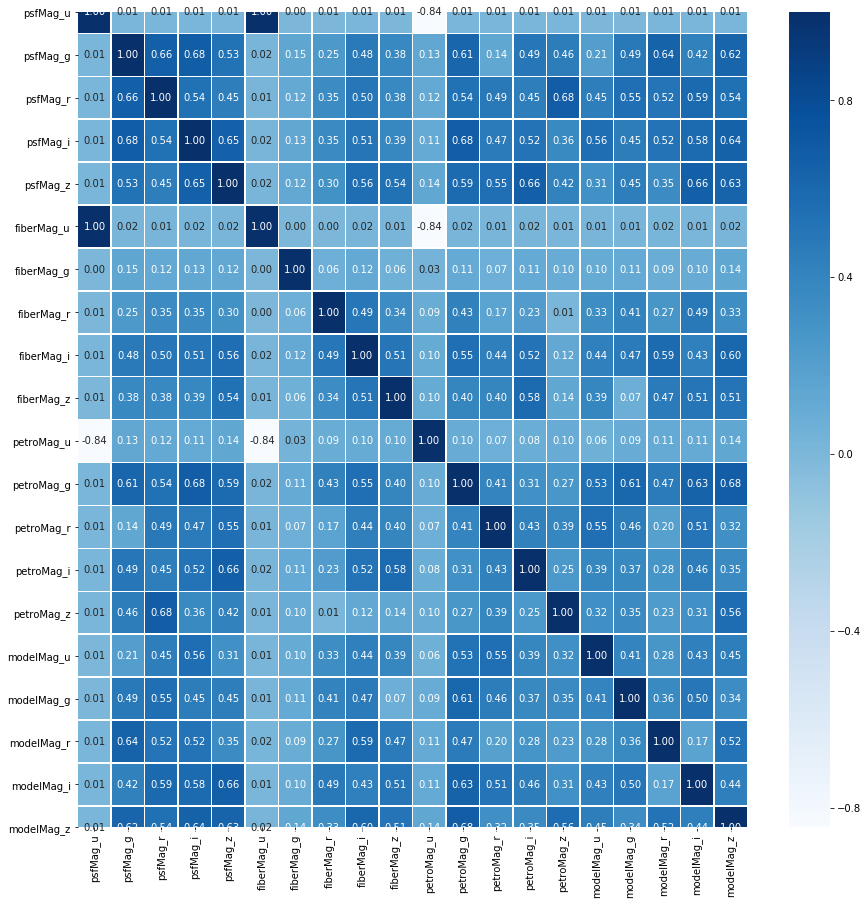

In [25]:
import seaborn as sns 

plt.figure(figsize=(15,15))
corr = train_set.corr(method='pearson')
sns.heatmap(data = corr, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

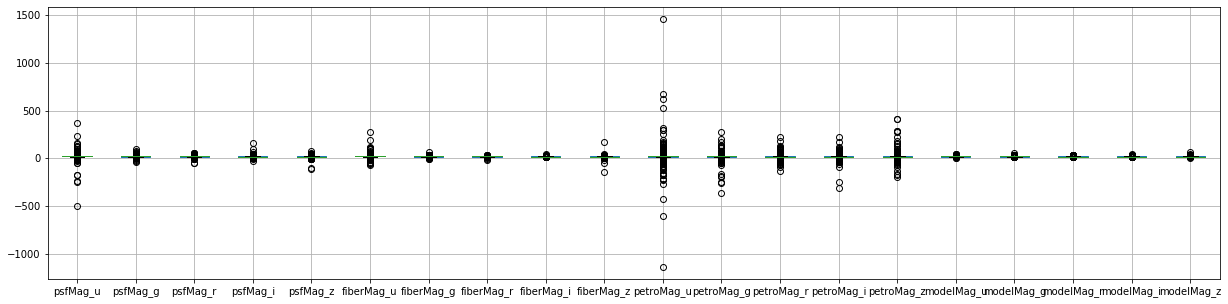

In [68]:
plt.figure(figsize=(21,5))
train_nOL.boxplot()

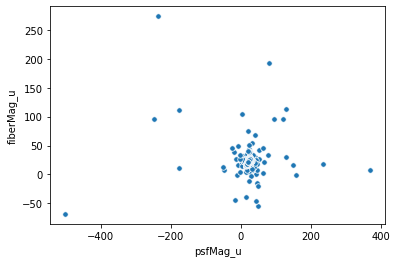

In [69]:
# psfMag_u
# fiberMag_u
# petroMag_u

sns.scatterplot(x='psfMag_u', y='fiberMag_u', 
                s=30, # marker size
                data=train_nOL)
plt.show()

ValueError: Could not interpret input 'type'

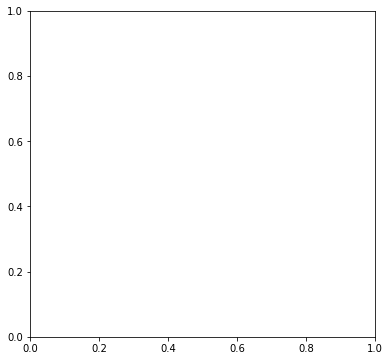

In [70]:

plt.figure(figsize=(21,6))

plt.subplot(131)
sns.scatterplot(x='psfMag_u', y='fiberMag_u', 
                hue='type', # different colors by group
                s=50, # marker size
                data=train_nOL)

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()

plt.subplot(132)
sns.scatterplot(x='psfMag_u', y='fiberMag_u', 
                hue='type', # different colors by group
                s=50, # marker size
                data=train_nOL)

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()

plt.subplot(133)
sns.scatterplot(x='fiberMag_u', y='petroMag_u', 
                hue='type', # different colors by group
                s=50, # marker size
                data=train_nOL)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()

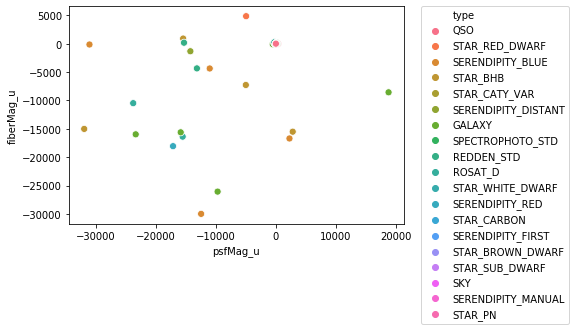

In [42]:
train_sub1 = train.loc[train['psfMag_u'] > -1000000]
train_sub2 = train.loc[train['psfMag_u'] <= -1000000]

sns.scatterplot(x='psfMag_u', y='fiberMag_u', 
                hue='type', # different colors by group
                s=50, # marker size
                data=train_sub1)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.3, 
                        random_state=1,
                        stratify=y)

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=1)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=1)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('에이다부스트의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (ada_train, ada_test))

결정 트리의 훈련 정확도/테스트 정확도 0.412/0.413
에이다부스트의 훈련 정확도/테스트 정확도 0.360/0.361
